> pip install -r requirements.txt

```
tensorflow==2.0
numpy
Pillow
opencv-python
seaborn
```

# Downloading official pretrained weights


https://pjreddie.com/media/files/yolov3.weights

# Using Custom trained weights

# Save the weights in Tensorflow format
Load the weights using load_weights.py script. This will convert the yolov3 weights into TensorFlow .ckpt model files!

``` python
python load_weights.py
```

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [32]:
!python load_weights.py

Model has been saved successfully.

2022-02-28 00:12:53.380779: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-02-28 00:12:53.381160: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-02-28 00:13:11.234044: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2022-02-28 00:13:11.234365: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-28 00:13:11.241880: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: W103PQYM53
2022-02-28 00:13:11.242468: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: W103PQYM53
2022-02-28 00:13:11.242856: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized

In [30]:
def load_weights(variables, file_name):
    """Reshapes and loads official pretrained Yolo weights.

    Args:
        variables: A list of tf.Variable to be assigned.
        file_name: A name of a file containing weights.

    Returns:
        A list of assign operations.
    """
    with open(file_name, "rb") as f:
        # Skip first 5 values containing irrelevant info
        np.fromfile(f, dtype=np.int32, count=5)
        weights = np.fromfile(f, dtype=np.float32)

        assign_ops = []
        ptr = 0

        # Load weights for Darknet part.
        # Each convolution layer has batch normalization.
        for i in range(52):
            conv_var = variables[5 * i]
            gamma, beta, mean, variance = variables[5 * i + 1:5 * i + 5]
            batch_norm_vars = [beta, gamma, mean, variance]

            for var in batch_norm_vars:
                shape = var.shape.as_list()
                num_params = np.prod(shape)
                var_weights = weights[ptr:ptr + num_params].reshape(shape)
                ptr += num_params
                assign_ops.append(tf.compat.v1.assign(var, var_weights))

            shape = conv_var.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(
                (shape[3], shape[2], shape[0], shape[1]))
            var_weights = np.transpose(var_weights, (2, 3, 1, 0))
            ptr += num_params
            assign_ops.append(tf.compat.v1.assign(conv_var, var_weights))

        # Loading weights for Yolo part.
        # 7th, 15th and 23rd convolution layer has biases and no batch norm.
        ranges = [range(0, 6), range(6, 13), range(13, 20)]
        unnormalized = [6, 13, 20]
        for j in range(3):
            for i in ranges[j]:
                current = 52 * 5 + 5 * i + j * 2
                conv_var = variables[current]
                gamma, beta, mean, variance =  \
                    variables[current + 1:current + 5]
                batch_norm_vars = [beta, gamma, mean, variance]

                for var in batch_norm_vars:
                    shape = var.shape.as_list()
                    num_params = np.prod(shape)
                    var_weights = weights[ptr:ptr + num_params].reshape(shape)
                    ptr += num_params
                    assign_ops.append(tf.compat.v1.assign(var, var_weights))

                shape = conv_var.shape.as_list()
                num_params = np.prod(shape)
                var_weights = weights[ptr:ptr + num_params].reshape(
                    (shape[3], shape[2], shape[0], shape[1]))
                var_weights = np.transpose(var_weights, (2, 3, 1, 0))
                ptr += num_params
                assign_ops.append(tf.compat.v1.assign(conv_var, var_weights))

            bias = variables[52 * 5 + unnormalized[j] * 5 + j * 2 + 1]
            shape = bias.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(shape)
            ptr += num_params
            assign_ops.append(tf.compat.v1.assign(bias, var_weights))

            conv_var = variables[52 * 5 + unnormalized[j] * 5 + j * 2]
            shape = conv_var.shape.as_list()
            num_params = np.prod(shape)
            var_weights = weights[ptr:ptr + num_params].reshape(
                (shape[3], shape[2], shape[0], shape[1]))
            var_weights = np.transpose(var_weights, (2, 3, 1, 0))
            ptr += num_params
            assign_ops.append(tf.compat.v1.assign(conv_var, var_weights))

    return assign_ops

In [3]:
import sys, os
BASE_DIR = os.path.abspath(os.path.dirname('__file__'))
sys.path.append(BASE_DIR)

In [55]:
import tensorflow as tf
import numpy as np
from yolo_v3 import Yolo_v3
tf.compat.v1.disable_eager_execution()

tf.compat.v1.reset_default_graph() # 如果命令行，这一句可以没有，ipynb里执行，这句必须有，否则导入不了模型

#from load_weights import load_weights

model = Yolo_v3(n_classes=80, model_size=(416, 416),
                max_output_size=5,
                iou_threshold=0.5,
                confidence_threshold=0.5,
                data_format = 'channels_last')

inputs = tf.compat.v1.placeholder(tf.float32, [1, 416, 416, 3])

model(inputs, training=False)

model_vars = tf.compat.v1.global_variables(scope='yolo_v3_model')
assign_ops = load_weights(model_vars, './models/yolo-coco/weights/yolov3.weights')

saver = tf.compat.v1.train.Saver(tf.compat.v1.global_variables(scope='yolo_v3_model'))

output_file = os.path.join(BASE_DIR, 'models','yolo-coco','weights','model.ckpt')
print(output_file)

with tf.compat.v1.Session() as sess:
    sess.run(assign_ops)
    #saver.save(sess, './models/yolo-coco/weights/model.ckpt')
    saver.save(sess, output_file)
    print('Model has been saved successfully.')

C:\Users\bin_he4\OneDrive - Dell Technologies\working\yolo-object-detection\models\yolo-coco\weights\model.ckpt
Model has been saved successfully.


生成文件
- checkpoint
- model.ckpt.data-00000-of-00001
- model.ckpt.index
- model.ckpt.meta

# Running the model
## Usage

> python detect.py <images/video/webcam> <iou threshold> <confidence threshold> <filenames>
    

## Images example
```
python detect.py images 0.5 0.5 data/images/dog.jpg data/images/office.jpg
```

In [38]:
!python detect.py images 0.5 0.5 images/dining_table.jpg

bottle 99.60%
wine glass 99.96%
wine glass 99.60%
diningtable 60.57%
vase 99.96%
Detections have been saved successfully.


2022-02-28 00:14:35.510990: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-02-28 00:14:35.511299: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-02-28 00:14:44.142805: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2022-02-28 00:14:44.143173: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-28 00:14:44.152380: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: W103PQYM53
2022-02-28 00:14:44.153103: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: W103PQYM53
2022-02-28 00:14:44.153571: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized

In [4]:
type, iou_threshold, confidence_threshold, input_names = ("images", 0.5, 0.5, "images/dining_table.jpg")
print(type, iou_threshold, confidence_threshold, input_names)

#print(input_names.split('/'))

input_names = os.path.join(BASE_DIR, *input_names.split('/'))

input_names = [input_names,]

print(input_names)

images 0.5 0.5 images/dining_table.jpg
['C:\\Users\\bin_he4\\OneDrive - Dell Technologies\\working\\yolo-object-detection\\images\\dining_table.jpg']


In [5]:
import tensorflow as tf
import sys
import cv2

from yolo_v3 import Yolo_v3
from utils import load_images, load_class_names, draw_boxes, draw_frame

In [6]:
tf.compat.v1.disable_eager_execution()

_MODEL_SIZE = (416, 416)
_CLASS_NAMES_FILE = './models/yolo-coco/labels/coco.names'
_MAX_OUTPUT_SIZE = 20

tf.compat.v1.reset_default_graph()

In [7]:
class_names = load_class_names(_CLASS_NAMES_FILE)
n_classes = len(class_names)

model = Yolo_v3(n_classes=n_classes, model_size=_MODEL_SIZE,
                max_output_size=_MAX_OUTPUT_SIZE,
                iou_threshold=iou_threshold,
                confidence_threshold=confidence_threshold,
                data_format = 'channels_last')

In [8]:
batch_size = len(input_names)
batch = load_images(input_names, model_size=_MODEL_SIZE)
inputs = tf.compat.v1.placeholder(tf.float32, [batch_size, *_MODEL_SIZE, 3])
detections = model(inputs, training=False)
saver = tf.compat.v1.train.Saver(tf.compat.v1.global_variables(scope='yolo_v3_model'))

In [9]:
with tf.compat.v1.Session() as sess:
    saver.restore(sess, './models/yolo-coco/weights/model.ckpt')
    detection_result = sess.run(detections, feed_dict={inputs: batch})

image_saved = draw_boxes(input_names, detection_result, class_names, _MODEL_SIZE)

print('Detections {} have been saved successfully.'.format(image_saved))

INFO:tensorflow:Restoring parameters from ./models/yolo-coco/weights/model.ckpt
bottle 99.60%
wine glass 99.96%
wine glass 99.60%
diningtable 60.57%
vase 99.96%
./detections/detection_1.jpg
./detections/detection_1.jpg
Detections ./detections/detection_1.jpg have been saved successfully.


---
错误：NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint.

解决：添加```tf.reset_default_graph()```
这条语句用来重置图，可能是因为图没有重置，导致检查点找不到所以导入不了模型
实际操作：在有关图的变量定义前加入tf.reset_default_graph()，问题解决，可以正常读取保存的文件

https://blog.csdn.net/RObot_123/article/details/103517953

In [11]:
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
output_image = scipy.misc.imread(image_saved)
imshow(output_image)

AttributeError: module 'scipy.misc' has no attribute 'imread'

官方scipy中提到，imread is deprecated! imread is deprecated in SciPy 1.0.0, and will be removed in 1.2.0. Use imageio.imread instead.

SciPy1.0.0不赞成使用imread，在1.2中已经弃用，可以使用imageio.imread来代替。

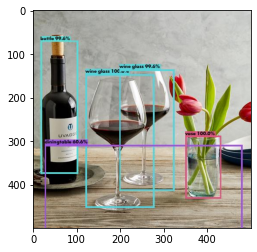

In [16]:
from matplotlib.pyplot import imshow
import imageio
content_image = imageio.imread(image_saved)
imshow(content_image)

Text(0.5, 1.0, 'result')

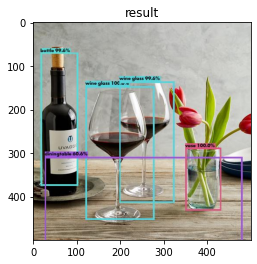

In [13]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread(image_saved)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('result')

## Video example
```
python detect.py video 0.5 0.5 data/video/shinjuku.mp4
```


In [49]:
!python detect.py video 0.5 0.5 data/video/shinjuku.mp4

^C


## Webcam example

```
python detect.py webcam 0.5 0.5
```